# DepthGan model to estimate depth from a single image. 
Based on Pix2Pix Architectire


In [7]:
!nvidia-smi

Sat Jun  3 14:23:36 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.79                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 T...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   47C    P8               17W /  N/A|   5918MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
#from google.colab import drive
#drive.mount('/content/drive')
import tensorflow as tf
import json
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version: 2.10.1
Num GPUs Available:  1


## 1) Data preprocessing

### **Partition of the image directions**

De 1495 imagenes, 1196 son destinadas al entrenamiento y 299 para testing



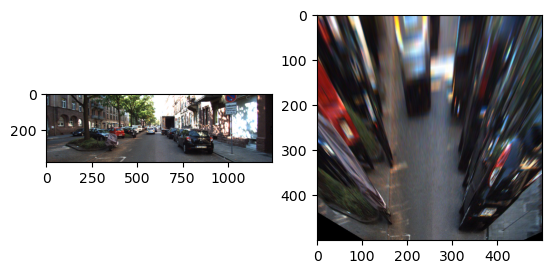


The input image is of size (375, 1242, 3) and target image of size (500, 500, 3).


In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

SEED= 5
DataTreatment=0

#Ruta raiz
#PATH = '/content/drive/MyDrive/2. MUAR/Pattern Recognition and Machine Learning/Final Assessment/DepthGAN'
ROOT_PATH = r'C:\Users\vesga\Documentos\UPC\Master Robotica\Machine learning\Final Project\Dataset'

#Ruta datos de entrada
IN_DIR = ROOT_PATH + '/all_input/'
#INPATH = PATH + '/input_images/'

#Ruta datos de salida
OUT_DIR = ROOT_PATH + '/all_target/'
#OUTPATH = PATH + '/target_images_jpg/'

# Ruta de salida para plots
global PLT_PATH
PLT_PATH = r'C:\Users\vesga\Documentos\UPC\Master Robotica\Machine learning\Final Project\Dataset\Plots'

# Ruta checkpoints
CK_PATH = ROOT_PATH + r'\checkpoints'

# Ruta dataset ya augmentado
TRAIN_DIR=ROOT_PATH + r'\train_data'
TEST_DIR=ROOT_PATH + r'\test_data'

# Rutas completas
PATH = os.path.abspath(ROOT_PATH)
INPATH = os.path.join(PATH, IN_DIR)
OUTPATH = os.path.join(PATH, OUT_DIR)
PLT_PATH = os.path.join(PATH, PLT_PATH)
CKPATH = os.path.join(PATH, CK_PATH)
TRAINPATH= os.path.join(PATH, TRAIN_DIR)
TESTPATH= os.path.join(PATH, TEST_DIR)

#Guardamos el nombre de todas las imagenes de entrada con comando bash
imgurls = os.listdir(INPATH)

#Randomize data order as it is ordered by timestamp
n = len(imgurls) #numero de imagenes del dataset
train_n = round(n * 0.8)

#Listado pseudo-randomizado (el mismo entre ejecuciones en caso que se vuelva a ejecutar la celda)
randurls = np.copy(imgurls)
np.random.seed(SEED)
np.random.shuffle(randurls)

#Particion en train y test
tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print('De {} imagenes, {} son destinadas al entrenamiento y {} para testing\n'.format(len(imgurls), len(tr_urls), len(ts_urls)))

in_im = plt.imread(INPATH + randurls[0])
tg_im = plt.imread(OUTPATH + randurls[0])

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(in_im)
ax2.imshow(tg_im)
plt.show()

print('\nThe input image is of size {} and target image of size {}.'.format(in_im.shape, tg_im.shape))

### **Load images and preprocessing**

1.   Define resize function
2.   Define normalization function
3.   Augmentation with random Jitter




The input image is of size (128, 128, 3) and target image of size (128, 128, 3).


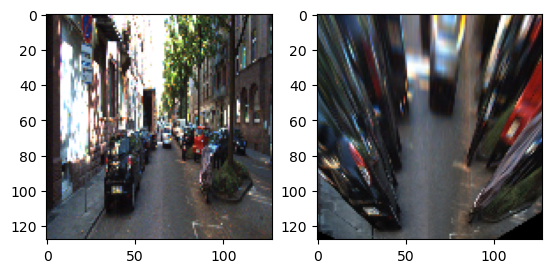


The input image is of size (128, 128, 3) and target image of size (128, 128, 3).


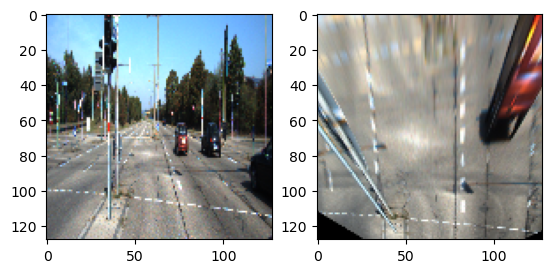

In [10]:
IMG_WIDTH = 128
IMG_HEIGHT = 128

#Reescalar imagenes
def resize(inimg, tgimg, height=IMG_WIDTH, width=IMG_HEIGHT):

  inimg = tf.image.resize(inimg, [height, width])
  tgimg = tf.image.resize(tgimg, [height, width])

  return inimg, tgimg

#Trabajar en el dominio de 0 a 1
def normalize(inimg, tgimg):

  inimg = (inimg / 127.5) - 1
  tgimg = (tgimg / 127.5) - 1

  return inimg, tgimg

@tf.function()
def random_jitter(inimg, tgimg):

  inimg, tgimg = resize(inimg, tgimg)
  #print('BEFORE STACK: The input image is of size {} and target image of size {}.\n '.format(inimg.shape, tgimg.shape))

  #Apilamos las dos imagenes.
  stacked_image = tf.stack([inimg, tgimg], axis=0)
  #print('AFTER STACK: The image is of size {}.\n '.format(stacked_image.shape))
  
  #recortamos la imagen de 286 a 256 con un crop random
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
  
  #recuperamos las imagenes origiales y las desapilamos
  inimg, tgimg = cropped_image[0] , cropped_image[1]

  #print('AFTER CROP: The input image is of size {} and target image of size {}.\n '.format(inimg.shape, tgimg.shape))

  if tf.random.uniform(()) > 0.5:
    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)
  
  return inimg, tgimg

#cargar las imagenes
def load_image(filename, augment=True):

  #cargamos las imagenes y espacificamos que solo queremos los tres canales RGB para evitar problemas con las imagenes PNG
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)), tf.float32)[...,:3]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPATH + '/' + filename)), tf.float32)[...,:3]

  #hacemos el resize pero no estoy seguro si hacerlo porque en el random jitter ya lo hace
  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)

  if (augment==True):
    inimg, tgimg = random_jitter(inimg, tgimg)
  
  inimg, tgimg = normalize(inimg, tgimg)   
    
  return inimg, tgimg

def load_train_image(filename):
  return load_image(filename, True)

def load_test_image(filename):
  return load_image(filename, False)

##### SANITY CHECK TO SEE IF ALL IS OKAY #####
inimg, tgimg = load_train_image(tr_urls[0])
print('\nThe input image is of size {} and target image of size {}.'.format(inimg.shape, tgimg.shape))
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow((inimg + 1 ) / 2)
ax2.imshow((tgimg + 1 ) / 2)
plt.show()

##### SANITY CHECK TO SEE IF ALL IS OKAY #####
inimg, tgimg = load_test_image(ts_urls[0])
print('\nThe input image is of size {} and target image of size {}.'.format(inimg.shape, tgimg.shape))
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow((inimg + 1 ) / 2)
ax2.imshow((tgimg + 1 ) / 2)
plt.show()

### Load images on dataset after preprocessing them:

0
(2, 128, 128, 3)


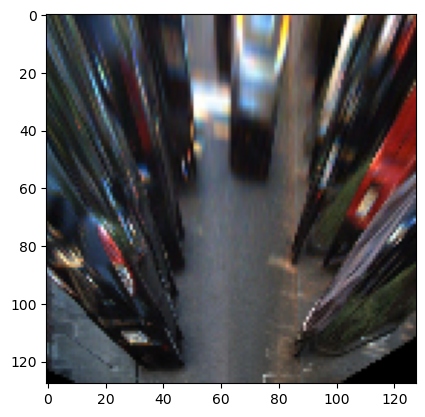

(2, 128, 128, 3)


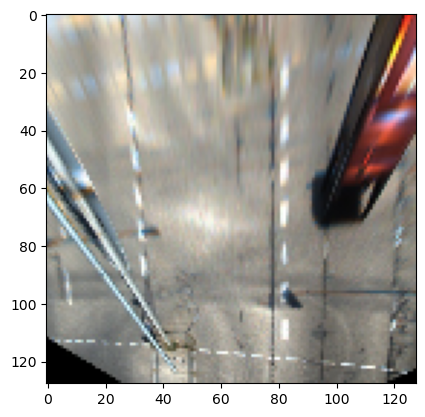

In [11]:
# Genera los datasets si todavia no habian sido generados antes.
if (DataTreatment == 1):  
  #Con esto generaremos un dataset con un listado de elementos que le digamos
  train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
  #mapea el dataset geneado con la funcion que le digamos para cargar las imagenes
  train_dataset = train_dataset.map(load_train_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
  #Distribuimos los datos en diferentes lotes (Batch). En el paper se especifica batch size = 1
  batch = 2
  train_dataset = train_dataset.batch(batch)

  #Hacemos la misma operativa con el dataset de testing
  #Con esto generaremos un dataset con un listado de elementos que le digamos
  test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
  #mapea el dataset geneado con la funcion que le digamos para cargar las imagenes
  test_dataset = test_dataset.map(load_test_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
  #Distribuimos los datos en diferentes lotes (Batch). En el paper se especifica batch size = 1
  test_dataset = test_dataset.batch(batch)

  # Guardamos el dataset en el directorio destinado a ello
  train_dataset.save(TRAINPATH)
  test_dataset.save(TESTPATH)
  
# Carga los datasets si ya habian sido generados antes.
else:
  train_dataset=tf.data.Dataset.load(TRAINPATH)
  test_dataset=tf.data.Dataset.load(TESTPATH)
  print(DataTreatment)

##### SANITY CHECK TO SEE IF ALL IS OKAY #####
for in_img, tg_img in train_dataset.take(1):
  print(tg_img.shape)
  plt.imshow((tg_img[0,...] + 1 ) / 2)
  plt.show()
  
for in_img, tg_img in test_dataset.take(1):
  print(tg_img.shape)
  plt.imshow((tg_img[0,...] + 1 ) / 2)
  plt.show()

## 2) Pix2Pix architecture

In [12]:
#Library to ✨visualize✨ the nets lately
!pip install visualkeras
import visualkeras

### Encoder (Unet Downsample)

In [13]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

#NUMBER OF OUTPUT LAYER IMAGE CHANNELS. 
#If we want the output layer to only have 1 color channel n=1, if generated image is rgb n=3
chnl_num = 3

#encoder
def downsample(filters, apply_batchnorm=True):

  result = Sequential()

  initializer = tf.random_normal_initializer(0, 0.02)

  #Capa convolucional
  result.add(Conv2D(filters,
             kernel_size = 4,
             strides = 2,
             padding = 'same', 
             kernel_initializer=initializer,
             use_bias = not apply_batchnorm))

  if apply_batchnorm:
    # Capa de Batch Normalization
    result.add(BatchNormalization())

  #Capa de activación
  result.add(LeakyReLU())

  return result

##### SANITY CHECK TO SEE IF ALL IS OKAY #####
down_model = downsample(3)
down_result = down_model(tf.expand_dims(inimg, 0))
print (down_result.shape)

(1, 64, 64, 3)


### Decoder (Unet Upsampler)

In [14]:
from tensorflow.python.ops.gen_nn_ops import Conv2DBackpropFilter
#decoder
def upsample(filters, apply_dropout=True):

  result = Sequential()

  initializer = tf.random_normal_initializer(0, 0.02)

  #Capa convolucional
  result.add(Conv2DTranspose(filters,
                             kernel_size = 4,
                             strides = 2,
                             padding = 'same', 
                             kernel_initializer=initializer,
                             use_bias = False))

  # Capa de Batch Normalization
  result.add(BatchNormalization())

  if apply_dropout:
    #Capa de dropout (Desconecta conexiones para regularizar la red)
    result.add(Dropout(0.5))

  #Capa de activación
  result.add(ReLU())

  return result

##### SANITY CHECK TO SEE IF ALL IS OKAY #####
up_model = upsample(3)
up_result = up_model(down_result)
print (up_result.shape)

(1, 128, 128, 3)


### UNet (Downsample+Upsample)

(2, 128, 128, 3)


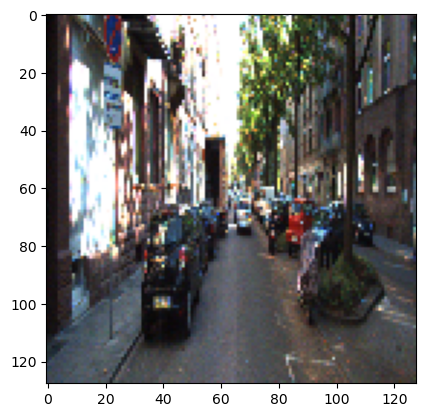

In [15]:
from pyparsing.core import SkipTo
from keras.layers.serialization import activation
def Generator():

  #Pongo 'None' en vez de 256 para dar paso a imagenes de diferentes tamaños
  inputs = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 3])

  down_stack = [
    downsample(64, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128),  # (batch_size, 64, 64, 128)
    downsample(256),  # (batch_size, 32, 32, 256)
    downsample(512),  # (batch_size, 16, 16, 512)
    downsample(512),  # (batch_size, 8, 8, 512)
    downsample(512),  # (batch_size, 4, 4, 512)
    downsample(512),  # (batch_size, 2, 2, 512)
    # downsample(512),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512),  # (batch_size, 16, 16, 1024)
    upsample(256),  # (batch_size, 32, 32, 512)
    upsample(128),  # (batch_size, 64, 64, 256)
    # upsample(64),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  #El numero de filtros va acorde con el numero de canales en el 
  #caso de querer generar rgb filters=3 si queremos generar escala de grises filters = 1
  
  last = Conv2DTranspose(filters = chnl_num,
                         kernel_size = 4,
                         strides = 2,
                         padding = 'same',
                         kernel_initializer = initializer, 
                         activation = 'tanh')

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
    
  #Invertimos las capas del codificador excepto la del cuello de botella (penultimo elemento) para luego poder conectar con el decoder
  skips = reversed(skips[:-1])
  
  #decodificador + concatencacion de las skip conections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])
  
  x = last(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

#load an image for testing pourposes
for in_img, tg_img in train_dataset.take(1):
  plt.imshow((in_img[0,...] + 1 ) / 2)
  test_im = (in_img + 1 ) / 2
  print(test_im.shape)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 128, 128, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

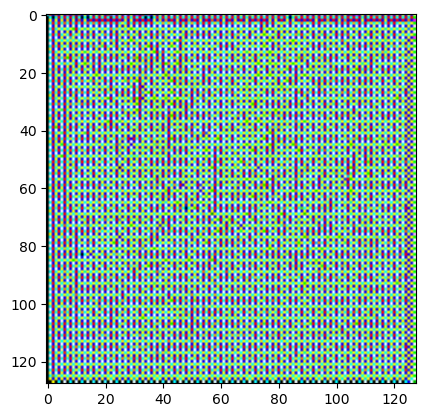

In [16]:
generator = Generator()
#test_im = np.expand_dims(test_im, axis=0); #Ejecutar en caso de que las dimensiones sean [256, 256, 3] en vez de [1, 256, 256, 3]
gen_output = generator(((test_im+1)*255), training=False)
print(gen_output.shape)
plt.imshow(gen_output[0,...])
plt.show

In [17]:
utils.plot_model(generator, show_shapes=True, dpi=64)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


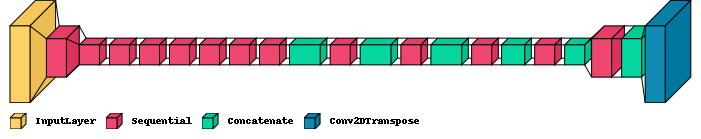

In [18]:
visualkeras.layered_view(Generator(), legend=True, scale_xy=0.6, scale_z=0.03)

### Discriminator (patchGAN)

The paper does not use a CNN as a typical discriminator (0 or 1), it uses a patchGan. Instead of return a 0 or 1, it returns a matrix of values (patches) where the values correspond to more real or fake values of the target image.

(Basically is like a CNN cutted by the end)

In [19]:
def Discriminator():
  # El discriminador debe tener acceso a la imagen original i a la generada, por lo tanto necesita tener 2 inputs
  ini = Input(shape = [IMG_WIDTH, IMG_HEIGHT, 3], name='input_img')
  gen = Input(shape = [IMG_WIDTH, IMG_HEIGHT, chnl_num], name='gener_img')

  con = concatenate([ini, gen])

  initializer = tf.random_normal_initializer(0., 0.02)

  down1 = downsample(64, apply_batchnorm = True)(con)  # (batch_size, 128, 128, 64)
  #down2 = downsample(128)(down1)  # (batch_size, 64, 64, 128)
  #down3 = downsample(256)(down2)  # (batch_size, 32, 32, 256)
  #down4 = downsample(512)(down3)  # (batch_size, 16, 16, 512)

  #aplicamos 1 filtro para que solo haya 1 canal -> valor real o no real para cada pixel
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down1)
  last = Conv2D(filters = 1,kernel_size = 4,strides = 1, padding = 'same',kernel_initializer = initializer)(zero_pad1)
  
  return tf.keras.Model(inputs = [ini, gen], outputs=last)


(2, 66, 66, 1)
66


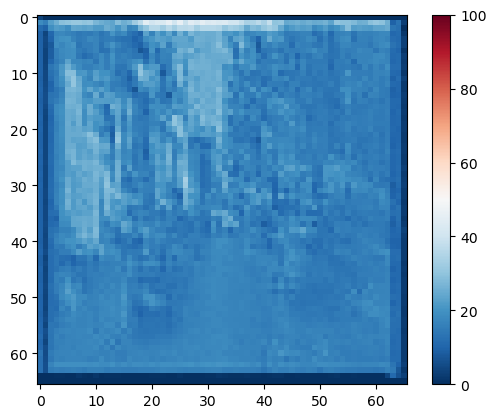

In [20]:
discriminator = Discriminator()
disc_out = discriminator([((test_im+1)*255), gen_output], training = False)
plt.imshow(disc_out[0,...,-1], vmin = 0, vmax = 100, cmap = 'RdBu_r')
plt.colorbar()
shape = disc_out.shape
print(shape)
global patch_size
patch_size = shape[2]
print(patch_size)

In [21]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


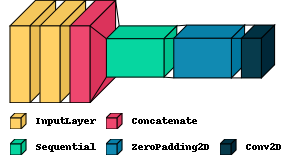

In [22]:
visualkeras.layered_view(Discriminator(), legend=True, scale_xy=0.6, scale_z=0.9)

### Adversial cost function
Basically this will merge the result from the generator and discriminator. And will be the one that makes the comptition between the 2 nets during the training.

In [23]:
#Definir la function de coste con BinaryCrossentropy de keras para calcular la entropia cruzada de cada uno de los pixeles de las imagenes obtenidas
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
  # Diferencia entre la imagen real y la generada por el discriminador.
  # El resultado idoneo tendria que decir que todos los pixeles de la imagen son reales (calientes)
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  # Diferencia entre el resultado del discriminador y el generado por el generador
  # En un resultado ideal para el discriminador todos los valores tendrian que ser falsos (frios)
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  # Valor que definirá el discriminator loss
  total_disc_loss = real_loss + generated_loss

  return total_disc_loss


In [24]:
LAMBDA = 20

def generator_loss(disc_generated_output, gen_output, target):
  # El error adversario es el resultado del discriminador al observar la imagen generada y el resultado esperado (todo unos, caliente)
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Diferencia por pixeles en valor absoluto entre la imagen que queriamos generar y la generada.
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  # El hyperparametro LAMBDA nos permite regular el valor del peso de cada error. El paper recomienda 100.
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss


## 3) Optimizators + checkpoint generator

In [25]:
# Adam optimizator with hyperparameters specified by the original paper -> tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
#Upgrades on https://keras.io/examples/generative/gan_ada/. Here I found some tips to optimize the models
learning_rate_generator = 2e-4
learning_rate_discriminator = 2e-4
beta_1 = 0.5
beta_2 = 0.999

generator_optimizer = tf.keras.optimizers.Adam(learning_rate_generator, beta_1=beta_1, beta_2=beta_2)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate_discriminator, beta_1=beta_1, beta_2=beta_2)

# Guardamos estados de la ejecucion del entrenamiento
# Guardamos el estado de los optimizadores y de los generadores y discriminadores
checkpoint_prefix = os.path.join(CKPATH, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#### Codigo para restaurar el ultimo checkpoint del entrenamiento ####
#checkpoint.restore(tf.train.latest_checkpoint(CKPATH))

## 4) Generate images function
Write a function to plot some images during training.

- Pass images from the test set to the generator.
- The generator will then translate the input image into the output.
- The last step is to plot the predictions and voila!

Note: The `training=True` is intentional here since you want the batch statistics, while running the model on the test dataset. If you use `training=False`, you get the accumulated statistics learned from the training dataset (which you don't want).

In [26]:
def generate_images(model, test_input, tar, name, save_filename = False, display_imgs = True):
  prediction = model(test_input, training=True)

  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # Getting the pixel values in the [0, 1] range to plot.
      if i==2:
        plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
      else:
        plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
      if save_filename:
        plt.savefig(PATH + '/output/' + name + '.jpg', dpi=300)
  plt.show()

In [27]:
def generate_test_images(model, test_input, tar, name, save_filename = False, display_imgs = True):
  test_input= resize(test_input, None)

  prediction = model(test_input, training=True)

  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # Getting the pixel values in the [0, 1] range to plot.
      if i==2:
        plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
      else:
        plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
    if save_filename:
      #tf.keras.preprocessing.image.save_img(PATH + '/output/' + name + '.jpg', prediction[0, ...])
      plt.savefig(PATH + '/Output_test_results/' + name + '.jpg', dpi=300)
  plt.show()

In [28]:
def evaluate(model, test_input, name, save_filename = False, display_imgs = True):
  global patch_size
  test_input= resize(test_input, test_input)
  test_input = test_input[0]
  prediction = model(test_input, training=True)

  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  if display_imgs:
    for i in range(2):
      plt.subplot(1, 2, i+1)
      plt.title(title[i])
      # Getting the pixel values in the [0, 1] range to plot.
      if i==1:
        plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
      else:
        plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
    if save_filename:
      #tf.keras.preprocessing.image.save_img(PATH + '/output/' + name + '.jpg', prediction[0, ...])
      plt.savefig(PATH + '/Output_test_results/' + name + '.jpg', dpi=300)
  plt.show()

  return prediction[0], test_input

In [29]:
# Compute the frechet distance for a single batch
def frechet_calculation(real_imgs,gen_imgs):

    # Transform to numpy array to treat the mean, std and cov
    embedding_realimg=real_imgs.numpy().flatten()
    embedding_genimg=gen_imgs.numpy().flatten()
    
    # calculate mean and covariance statistics for each array
    mur, sigmar= embedding_realimg.mean(axis=0), np.cov(embedding_realimg, rowvar=False)
    mug, sigmag = embedding_genimg.mean(axis=0), np.cov(embedding_genimg,  rowvar=False)
    
    # calculate sum squared difference between means
    musdiff = np.sum((mur - mug)**2.0)
    # calculate sqrt of product between cov
    covmean = np.sqrt(sigmar.dot(sigmag))

    # check and correct imaginary numbers from sqrt in case it is complex
    if np.iscomplexobj(covmean):
       covmean = covmean.real

    # calculate the weighted frechet distance from a batch
    frechet_distance_val = musdiff + sigmar+sigmag-2.0*covmean

    return frechet_distance_val

# Function to plot losses and metrics for the system
def plot_losses(generator_losses, l1_loss, gen_gan_loss, discriminator_losses,frechet_dist,generator_acc, discriminator_acc,lr_gen=0):
    PLT_PATH = r'C:\Users\vesga\Documentos\UPC\Master Robotica\Machine learning\Final Project\Dataset\Plots'

    # An array of specific learning rates given to the function
    if (type(lr_gen)!=int):
        
        # Plot losses
        plt.figure(figsize=(10, 5))
        plt.plot(lr_gen,generator_losses, label='Generator Loss')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.title('Generator Losses')
        save_path = PLT_PATH + '/generator_loss_plot.png'
        plt.savefig(save_path)
        plt.show()
        plt.close()
        
        # Plot losses
        plt.figure(figsize=(10, 5))
        plt.plot(lr_gen,discriminator_losses, label='Discriminator Loss')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.title('Discriminator Losses')
        save_path = PLT_PATH + '/discriminator_loss_plot.png'
        plt.savefig(save_path)
        plt.show()
        plt.close()
        
        # Plot losses
        plt.figure(figsize=(10, 5))
        plt.plot(lr_gen,gen_gan_loss, label='GAN Loss')
        plt.xlabel('Iteration/Epoch')
        plt.ylabel('Loss')
        plt.title('Generator GAN Losses')
        save_path = PLT_PATH + '/generator_GAN_loss_plot.png'
        plt.savefig(save_path)
        plt.show()
        plt.close()
        
        # Plot losses
        plt.figure(figsize=(10, 5))
        plt.plot(lr_gen,l1_loss, label='L1 Loss')
        plt.xlabel('Iteration/Epoch')
        plt.ylabel('Loss')
        plt.title('Generator L1 Losses')
        save_path = PLT_PATH + '/discriminator_L1_loss_plot.png'
        plt.savefig(save_path)
        plt.show()
        plt.close()
    
        
    # At least one specific learning rate given to the function
    elif (lr_gen!=0):
        
        # Plot losses
        plt.figure(figsize=(10, 5))
        plt.plot(lr_gen,generator_losses, label='Generator Loss')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.title('Generator Losses')
        save_path = PLT_PATH + '/generator_loss_plot.png'
        plt.savefig(save_path)
        plt.show()
        plt.close()
        
        # Plot losses
        plt.figure(figsize=(10, 5))
        plt.plot(lr_gen,discriminator_losses, label='Discriminator Loss')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.title('Discriminator Losses')
        save_path = PLT_PATH + '/discriminator_loss_plot.png'
        plt.savefig(save_path)
        plt.show()
        plt.close()
        
        # Plot losses
        plt.figure(figsize=(10, 5))
        plt.plot(lr_gen,gen_gan_loss, label='GAN Loss')
        plt.xlabel('Iteration/Epoch')
        plt.ylabel('Loss')
        plt.title('Generator GAN Losses')
        save_path = PLT_PATH + '/generator_GAN_loss_plot.png'
        plt.savefig(save_path)
        plt.show()
        plt.close()
        
        # Plot losses
        plt.figure(figsize=(10, 5))
        plt.plot(lr_gen,l1_loss, label='L1 Loss')
        plt.xlabel('Iteration/Epoch')
        plt.ylabel('Loss')
        plt.title('Generator L1 Losses')
        save_path = PLT_PATH + '/discriminator_L1_loss_plot.png'
        plt.savefig(save_path)
        plt.show()
        plt.close()
    
    # No learning rate given, just plot as it is
    else:
       
        # Plot losses
        plt.figure(figsize=(10, 5))
        plt.plot(generator_losses, label='Generator Loss')
        plt.xlabel('Iteration/Epoch')
        plt.ylabel('Loss')
        plt.title('Generator Losses')
        save_path = PLT_PATH + '/generator_loss_plot.png'
        plt.savefig(save_path)
        plt.show()
        plt.close()
        
        # Plot losses
        plt.figure(figsize=(10, 5))
        plt.plot(discriminator_losses, label='Discriminator Loss')
        plt.xlabel('Iteration/Epoch')
        plt.ylabel('Loss')
        plt.title('Discriminator Losses')
        save_path = PLT_PATH + '/discriminator_loss_plot.png'
        plt.savefig(save_path)
        plt.show()
        plt.close()
        
        # Plot losses
        plt.figure(figsize=(10, 5))
        plt.plot(gen_gan_loss, label='GAN Loss')
        plt.xlabel('Iteration/Epoch')
        plt.ylabel('Loss')
        plt.title('Generator GAN Losses')
        save_path = PLT_PATH + '/generator_GAN_loss_plot.png'
        plt.savefig(save_path)
        plt.show()
        plt.close()
        
        # Plot losses
        plt.figure(figsize=(10, 5))
        plt.plot(l1_loss, label='L1 Loss')
        plt.xlabel('Iteration/Epoch')
        plt.ylabel('Loss')
        plt.title('Generator L1 Losses')
        save_path = PLT_PATH + '/generator_L1_loss_plot.png'
        plt.savefig(save_path)
        plt.show()
        plt.close()
        
    # Plot frechet distance
    plt.figure(figsize=(10, 5))
    plt.plot(frechet_dist, label='Frechet distance')
    plt.xlabel('Iteration/Epoch')
    plt.ylabel('Distance')
    plt.title('Fake vs Real images frechet distance')
    save_path = PLT_PATH + '/average_frechet_distance.png'
    plt.savefig(save_path)
    plt.legend()
    plt.show() 
    plt.close()   
        
    # Plot Generator Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(generator_acc)
    plt.xlabel('Iteration/Epoch')
    plt.ylabel('Discriminator fake accuracy')
    plt.title('Discriminator fake accuracy')
    save_path = PLT_PATH + '/disc_fake_accuracy.png'
    plt.savefig(save_path)
    plt.show()
    plt.close()

    # Plot Discriminator Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(discriminator_acc)
    plt.xlabel('Iteration/Epoch')
    plt.ylabel('Discriminator real accuracy')
    plt.title('Discriminator real accuracy')
    save_path = PLT_PATH + '/disc_real_accuracy.png'
    plt.savefig(save_path)
    plt.show()
    plt.close()

# Append at the end of each element of a json file the new metrics
def modifmetrics(filename,disc_loss,gen_loss,disc_real_acc,disc_fake_acc,frech_dist):
    
    # Load the file and obtain the data from the metrics
    metricdata=open(filename)
    data_obj=json.load(metricdata)
    
    # Update all values appending the last obtained on the epoch
    L=data_obj["disc_loss"]; L.append(disc_loss); data_obj["disc_loss"]=L
    L=data_obj["gen_loss"]; L.append(gen_loss); data_obj["gen_loss"]=L
    L=data_obj["disc_real_acc"]; L.append(disc_real_acc); data_obj["disc_real_acc"]=L
    L=data_obj["disc_fake_acc"]; L.append(disc_fake_acc); data_obj["disc_fake_acc"]=L
    L=data_obj["frech_dist"]; L.append(frech_dist); data_obj["frech_dist"]=L
    
    # Update data on the json file
    data=open(filename,"w")
    json.dump(data_obj,data,indent=2)
    data.close()
    metricdata.close()

## 5) Train rutine

In [30]:
from IPython.display import clear_output
from keras.models import load_model

@tf.function
def train_step(input_image, target):
    # Convert the target to grayscale if chnl_num == 1
    if chnl_num == 1:
        target = tf.image.rgb_to_grayscale(target)

    # Define the objects: Gradient tape of the generator and discriminator
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generator generates image
        gen_output = generator(input_image, training=True)

        # Discriminator evaluates the generated image and the real image
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        #Output size: tensor(batch_size, patch_size, patch_size, 1) -> Normalize the values so it it between -1 and 1      
        
        # Compute the generator loss functions
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        # Compute the discriminator loss function
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        # Calculate the gradients of the generator/discriminator (Register operations and calculate gradients)
        generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        # Optimize the parameters based on the calculated gradients
        generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_total_loss, disc_loss, gen_l1_loss, gen_gan_loss, disc_real_output, disc_generated_output, gen_output #,frech

def train(dataset, epochs):
    
    # Create lists to store generator and discriminator loss values, frechet distance and discriminator outputs
    generator_losses = []
    discriminator_losses = []
    l1_losses=[]
    gan_losses=[]
    frechet_distance = []
    real_output_disc=[]
    fake_output_disc=[]
    
    for epoch in range(epochs):
        
        # Variables for each epoch, all losses, discriminator outputs and frechet distance
        imgi = 0
        epoch_gen_loss = 0.0
        epoch_disc_loss = 0.0
        epoch_l1_loss=0.0
        epoch_gan_loss=0.0
        frech_dist = 0.0
        disc_real_outpt=[]
        disc_gen_outpt=[]
        
        # Train the GAN with all dataset
        for input_image, target in dataset:
            
            print('epoch ' + str(epoch) + ' - train: ' + str(imgi) + '/' + str(len(tr_urls)))
            imgi += 1
            gen_total_loss, disc_loss, l1_loss, gan_loss, disc_real_out, disc_gen_out, gen_image= train_step(input_image, target)
            
            # Make post-processing of the Patch received from the GAN network:
            disc_real=tf.nn.tanh(disc_real_out); disc_gen=tf.nn.tanh(disc_gen_out)
            frechet=0
            for j in range (batch):
                
                # Get the values from discriminator for real and fake images on each batch
                disc_output_real=disc_real[j].numpy(); disc_output_gen=disc_gen[j].numpy()
                disc_real_acc=disc_output_real.mean(); disc_fake_acc=disc_output_gen.mean()
                
                # Get the frechet inception distance for each image on the batch and add it to frechet value
                frechet=frechet+frechet_calculation(target[j],gen_image[j])
                
                # Classify on real or fake upon the mean values of each image
                if (disc_real_acc>=0): disc_real_acc=1
                else: disc_real_acc=0
                if (disc_fake_acc>=0): disc_fake_acc=1
                else: disc_fake_acc=0
                
                #Add the values to the list of all images            
                disc_real_outpt.append(disc_real_acc)
                disc_gen_outpt.append(disc_fake_acc)
            
            # Print obtained values from the training step:
            print(f'Epoch {epoch}/{epochs}')
            print(f'Generator loss: {gen_total_loss}')
            print(f'Discriminator loss: {disc_loss}')
            print(f'Frechet distance: {frechet}')
            print(f'Discriminator real accuracy: {disc_real_acc*100}')
            print(f'Discriminator fake accuracy: {disc_fake_acc*100}')
            clear_output(wait=True)
            
            # Update the generator and discriminator losses at each batch together with the accuracies
            epoch_gen_loss += gen_total_loss
            epoch_disc_loss += disc_loss
            epoch_l1_loss+=l1_loss
            epoch_gan_loss+=gan_loss
            frech_dist += frechet
              
        # Calculate average losses and frechet distance for the epoch together with its accuracy
        epoch_gen_loss /= imgi
        epoch_disc_loss /= imgi
        epoch_l1_loss /= imgi
        epoch_gan_loss /= imgi
        disc_real_acc_epoch=sum(disc_real_outpt)/len(disc_real_outpt)
        disc_fake_acc_epoch=sum(disc_gen_outpt)/len(disc_real_outpt)
        frech_dist /= imgi

        # Append all values to the final list
        generator_losses.append(epoch_gen_loss)
        discriminator_losses.append(epoch_disc_loss)
        l1_losses.append(epoch_l1_loss)
        gan_losses.append(epoch_gan_loss)
        real_output_disc.append(disc_real_acc_epoch)
        fake_output_disc.append(disc_fake_acc_epoch)
        frechet_distance.append(frech_dist)
        
        # Plot the graphic with all the values and add it to the metrics saved
        plot_losses(generator_losses, l1_losses, gan_losses, discriminator_losses, frechet_distance, fake_output_disc, real_output_disc)
        modifmetrics(ROOT_PATH+"/metrics.json",float(epoch_disc_loss.numpy()),float(epoch_gen_loss.numpy()),float(disc_real_acc_epoch*100),float(disc_fake_acc_epoch*100),frech_dist) #frech_dist missing
            
        # Show results of current epoch with some examples 
        for inp, tar in test_dataset.take(3):
            generate_images(generator, inp, tar, str(imgi) + '_' + str(epoch), save_filename=True, display_imgs=True)
    
        # Guardando checkpoint cada x epochs
        x = 20
        if (epoch + 1) % x == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
    return generator_losses[:-1],discriminator_losses[:-1],real_output_disc[:-1],fake_output_disc[:-1] #frechet_distance[-1]

In [31]:
#### Codigo para restaurar el ultimo checkpoint del entrenamiento ####
#checkpoint.restore(tf.train.latest_checkpoint(CKPATH))

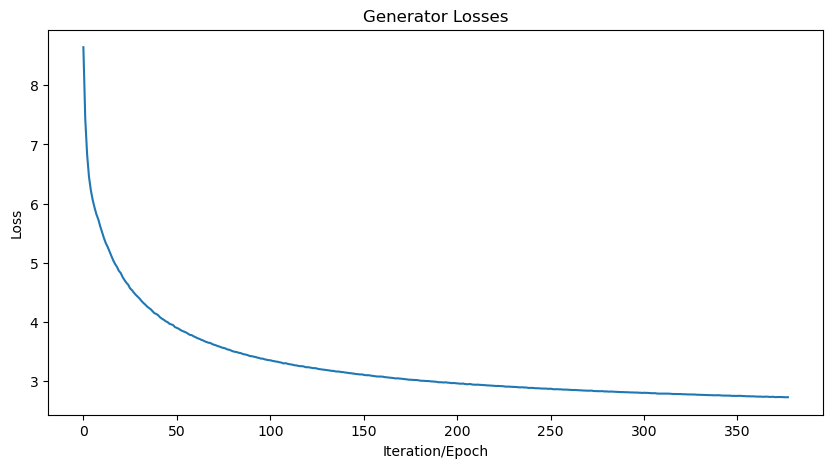

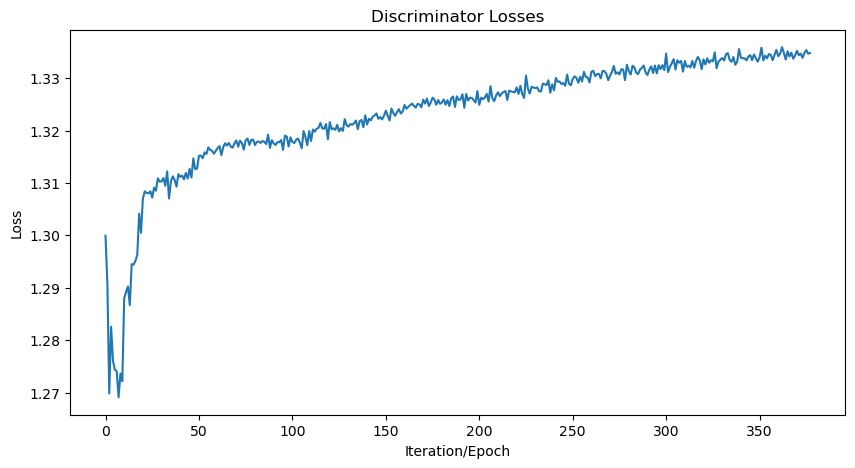

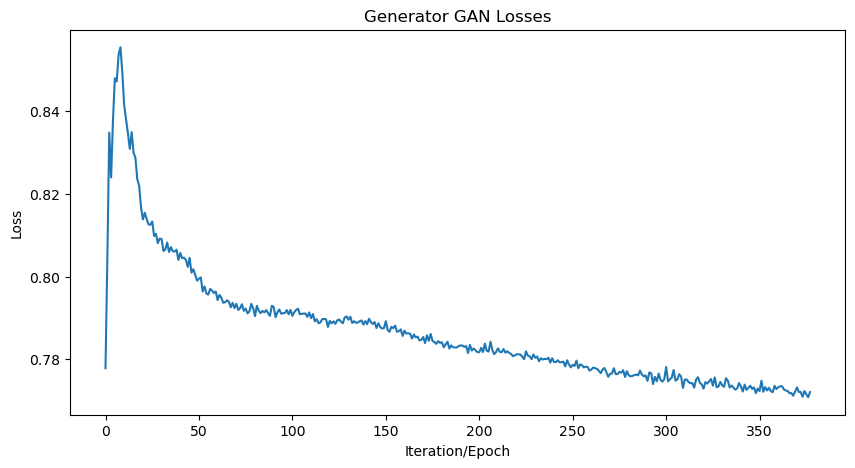

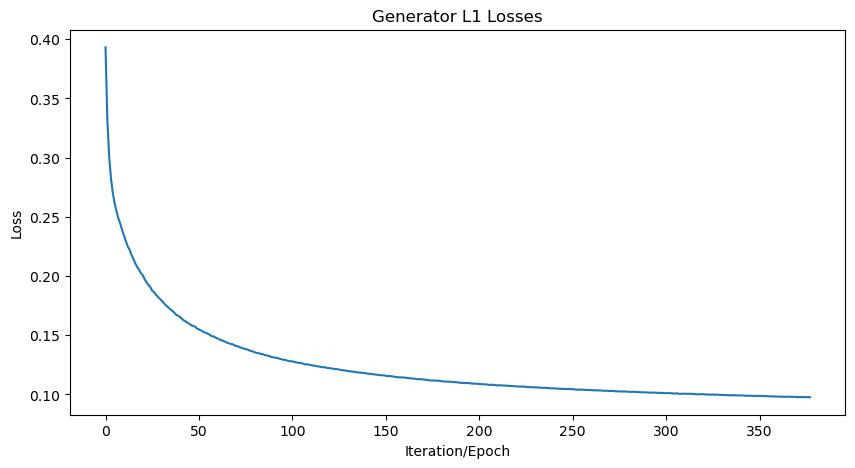

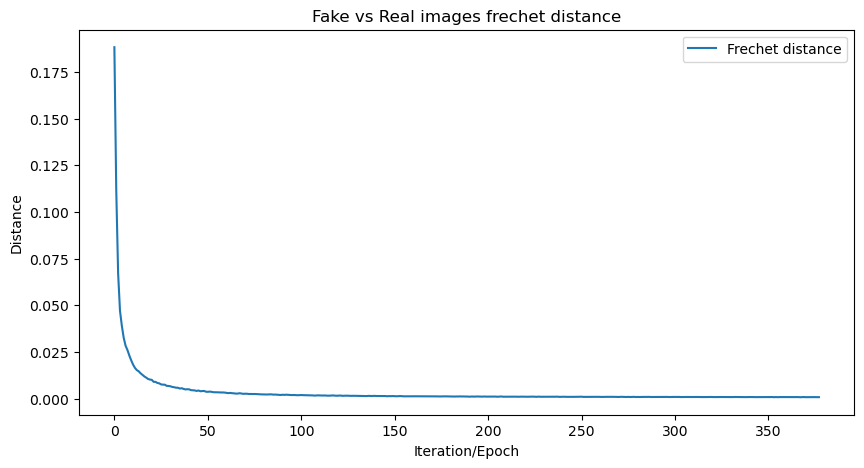

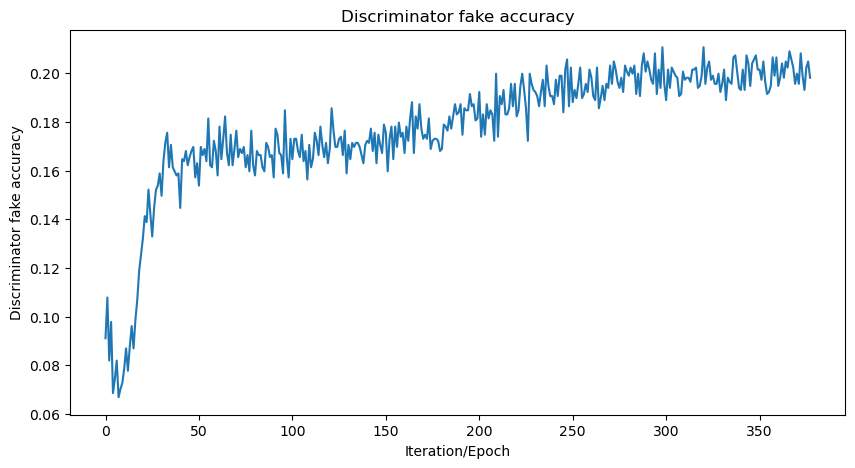

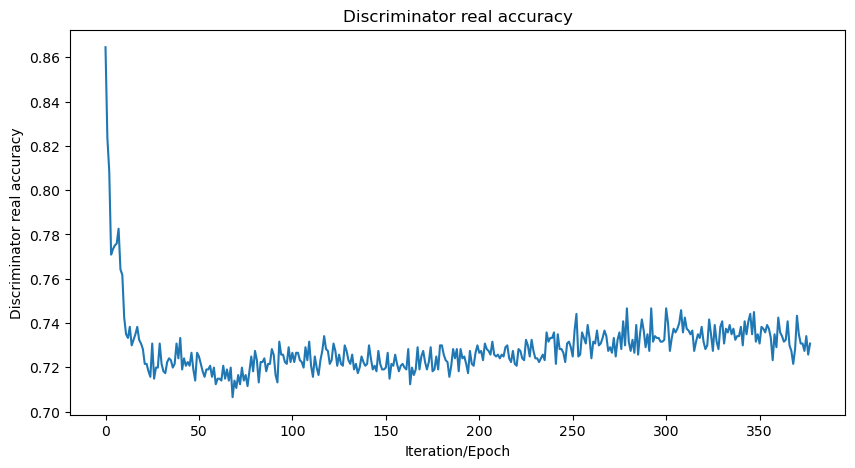

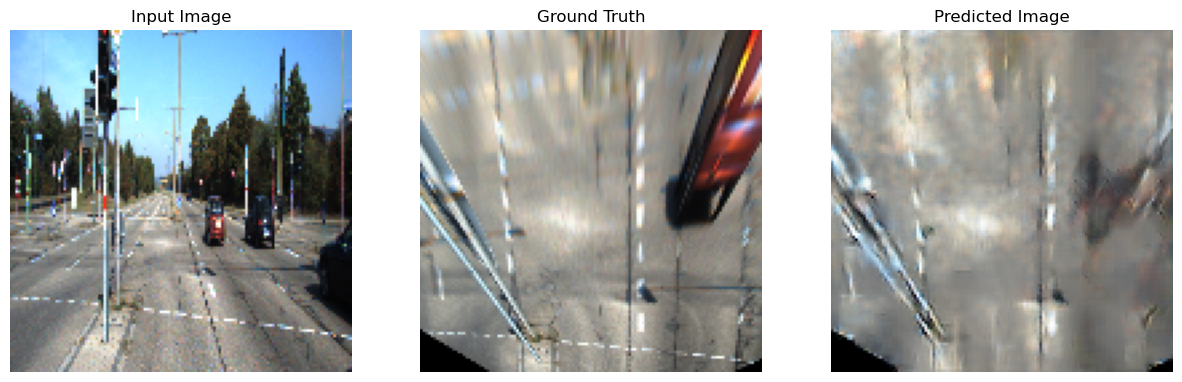

In [32]:
# Iterate over the values of the learning rate to check which is the best one for the system.
gen_loss_epc=[]; dis_loss_epc=[]; disc_realim_out=[]; disc_fakeim_out=[]; frech_d=[]; 
Start_epc=-5; Stop_epc=1; step=30
lr_gen=np.logspace(Start_epc,Stop_epc,step); lr_disc=np.logspace(Start_epc,Stop_epc,step)

# for i in range(len(lr_gen)):
  
#   # Store the last function loss for each iteration
#   gen_loss=0.0;disc_loss=0.0;disc_reout=0.0; disc_genout=0.0
  
#   # Create a new generator and a discriminator at each loop
#   discriminator=Discriminator()
#   generator=Generator()
  
#   # Create a new generator model for each iteration
#   generator_optimizer = tf.keras.optimizers.Adam(lr_gen[i], beta_1=beta_1, beta_2=beta_2)
#   discriminator_optimizer = tf.keras.optimizers.Adam(lr_disc[i], beta_1=beta_1, beta_2=beta_2)

#   # Make the training with 20 epochs at each step with the given learning rate
#   gen_loss,disc_loss,disc_reout,disc_genout=train(train_dataset, 20)

#   # Append the results to the list of function losses
#   gen_loss_epc.append(gen_loss); dis_loss_epc.append(disc_loss); #frech_d.append(frechet_d)
#   disc_realim_out.append(disc_reout); disc_fakeim_out.append(disc_genout)
  
#   # Plot the result for each given learning rate
#   #plot_losses(gen_loss,disc_loss,frechet_d,lr_gen[i])
#   print("Ending loop for learning rate: {}".format(i))
# Plot at the end all the losses
#plot_losses(gen_loss_epc,dis_loss_epc,disc_realim_out,disc_fakeim_out,disc_fakeim_out,lr_gen)

gen_loss,disc_loss,disc_reout,disc_genout=train(train_dataset,400)
gen_loss_epc.append(gen_loss); dis_loss_epc.append(disc_loss); #frech_d.append(frechet_d)
disc_realim_out.append(disc_reout); disc_fakeim_out.append(disc_genout) 

In [ ]:
#plt.plot(disc_realim_out)
#print(disc_realim_out)

## 6) Save/Load Model

Save

In [ ]:
generator.save(PATH + '/models/Iter6/generator_final.h5')

Load

In [ ]:
model = load_model(PATH + '/models/generator_final.h5')

## 7) Testing

In [ ]:
# i = 0
# for inp, tar in test_dataset.take(10):
#   name = 'test_' + str(i)
#   generate_test_images(model, inp, tar, name , save_filename = True, display_imgs = True)
#   i += 1

NOTA MENTAL: La manera de discriminar de manera correcta si el generador ya es suficientemente bueno o no lo basamos en el hecho de mirar la accuracy del discriminador tanto para las imágenes que son reales como para las imágenes que son fake. Si el discriminador no es suficientemente bueno clasificando imágenes reales y la accuracy de imagenes del generador es bastante buena, entonces es que el discriminador es malo. Por otro lado, si la accuracy de imagenes reales del discriminador es buena pero la accuracy de imagenes del generador tambien es buena, entonces el generador es bastante bueno.